In [25]:
import pandas as pd

# Read the Excel file
df = pd.read_excel('CRSPMonthly.xlsx')
df["re"] = df["rvwind"] - df["rf"]
# Display the first few rows of the dataframe
df.head()

,month,rvwind,rf,re
0,1927-01-01,0.002416,0.0025,-0.000084
1,1927-02-01,0.045370,0.0026,0.042770
2,1927-03-01,0.003756,0.0030,0.000756
3,1927-04-01,0.007225,0.0025,0.004725
4,1927-05-01,0.057773,0.0030,0.054773


In [29]:
import numpy as np

# 120 month lag, aligned s.t. the first observation is the 121st month (i.e. R[t] ~ R[t-120:t-1]+1)
df[f'lag_0'] = df['re'].rolling(window=120).mean().shift(1)


# Create the remaining predictors
for i in range(1,20):
  df[f'lag_{i}'] = df['lag_0'].shift(i*12)

# # Display the first few rows of the predictors dataframe
df = df[19*12+120:]
df.reset_index(drop=True, inplace=True)

In [118]:
def ridgeless_regression(Y, X):
    # Fit the model
    X = X.values
    Y = Y.values
    beta = np.linalg.pinv(X.T@X)@X.T@Y
    return beta

In [261]:
def rolling_window_regression(df, w):
    
    # Function to apply within each rolling window
    def apply_regression(x):
        # Ensure x is reshaped into a DataFrame for indexing
        # x_df = pd.DataFrame(x, columns=numeric_df.columns)
        Y = x['re']
        X = x.loc[:, 'lag_0':'lag_19']
        return pd.Series(ridgeless_regression(Y, X),name=x.index[-1])
    
    # Apply rolling regression
    rolling_results = df.groupby(df.index//w).apply(apply_regression)
    rolling_results = df.groupby(df.index//w).apply(apply_regression)
    
    reindex = (rolling_results.index+1)*w-1
    reindex = np.minimum(reindex, df.index.max())
    rolling_results.set_index(reindex,inplace=True)
    
    return rolling_results

def calc_rets(betas, df):
  # drop beta calculation that doesn't have full 'w' sized sample at end
  betas.drop(betas.index[-1], inplace=True)
  # reindex so we're using \beta[t] to predict R[t+1]
  betas.index = betas.index + 1
  betas.plot()
  exp_ret = (df.loc[betas.index, 'lag_0':'lag_19'] * betas.values).sum(axis=1)
  rets=df.loc[exp_ret.index, 're']
  mkt_timing_ret = exp_ret*rets
  return mkt_timing_ret

def sharpe_ratio(returns, w):
  return returns.mean() / returns.std() * np.sqrt(w)
  
def information_ratio(strat_rets, mkt_rets, w):
  import statsmodels.api as sm

  X = sm.add_constant(mkt_rets)
  mkt_beta = np.linalg.pinv(X.T@X)@X.T@strat_rets
  over_mkt_rets = strat_rets - mkt_beta[1]*mkt_rets
  over_mkt_rets = over_mkt_rets.round(10)
  return sharpe_ratio(over_mkt_rets, w)
    

/var/folders/cs/glpd34851nxfdyrvjyr6726m0000gn/T/ipykernel_69236/3103023134.py:33: RuntimeWarning: invalid value encountered in scalar divide
  return returns.mean() / returns.std() * np.sqrt(w)


,sharpe_ratio,information_ratio
w,,
3,0.023733,0.116215
12,-0.229408,0.031280
60,-7.266508,-5.516938
120,-11.465001,-10.145191
market (aligned with w=3),0.192050,NaN


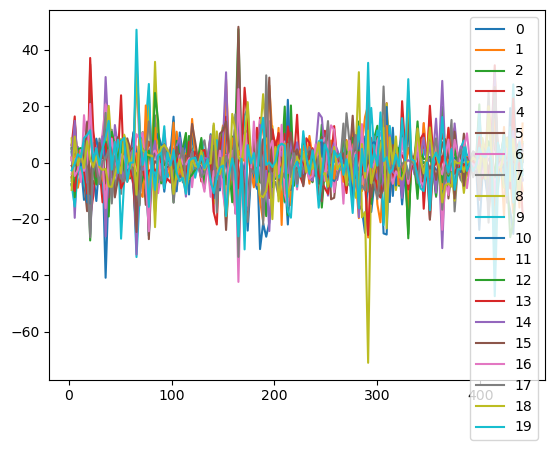

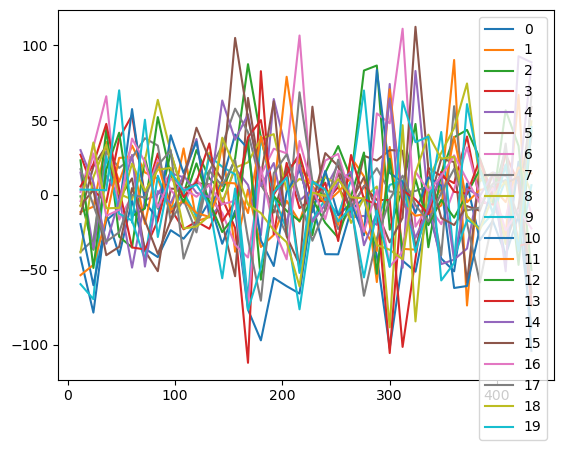

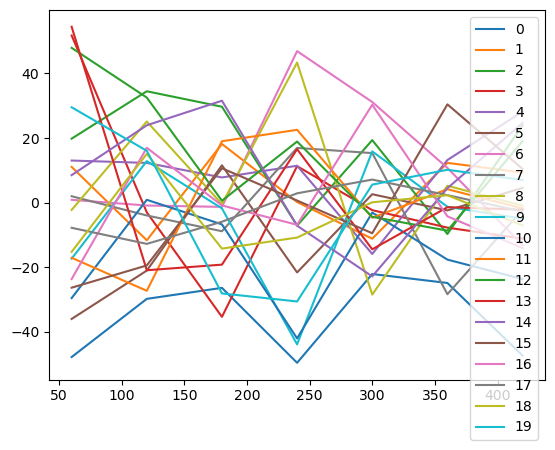

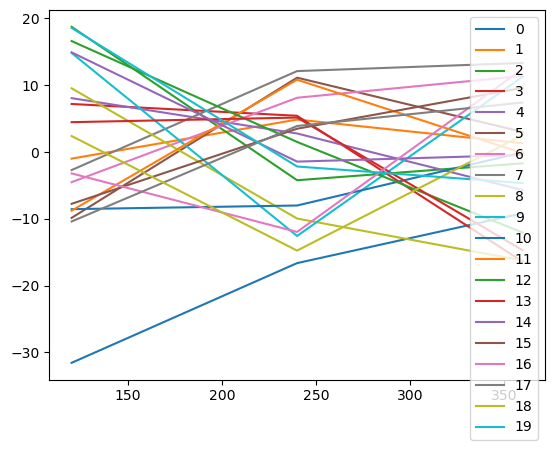

In [263]:
results ={
    'w': [3,12,60,120],
    'sharpe_ratio': [],
    'information_ratio': []
}
for w in results['w']:
  betas = rolling_window_regression(df,w)
  rets = calc_rets(betas, df)
  results['sharpe_ratio'].append(sharpe_ratio(rets, w))
  results['information_ratio'].append(information_ratio(rets, df.loc[rets.index,'re'], w))
  
qrtly_index = [i-1 for i in range(3, len(df),3)]
market_rets = df.loc[qrtly_index, 're']
results['w'].append('market (aligned with w=3)')
results['sharpe_ratio'].append(sharpe_ratio(market_rets, 3))
results['information_ratio'].append(information_ratio(market_rets, market_rets, 3))
pd.DataFrame(results).set_index('w')

Thoughts on pinv:

- can solve via SVD -> A = U@ S @Vt then A+ = V @ S^-1 @ Ut
- if A = X.t@X -> SVD: X.t@X = U @ S^2 @ Ut -> Ut @ S^-2 @ U
